# Predicting footballer player wage based on respective FIFA / EAFC plater stats

The problem we are addressing is correctly evaluating a playe's wage based on their stats. With ever more growing talent in the field, it is vital as a football club to accurately price your players to stay competitive. Our goal is to study & build machine learning models to accurately predict a footballer's wage based on a dataset of players wage and stats.

# Importing data

We are going to be utilising the [EA Sports FC 24 complete player dataset](https://www.kaggle.com/datasets/omkargowda/football-players-stats-premier-league-20212022/) from kaggle for player stats and valautions.

Required Python modules:
* Pandas - reading and manipulating data

In [198]:
import pandas as pd
# instructing pandas to not truncate column widths when displaying data in interactive mode
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

datasets_fp = 'datasets/'
encoding = 'unicode_escape'
df = pd.read_csv(datasets_fp+'male_players.csv', encoding=encoding)
df

C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\1495400085.py:8: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datasets_fp+'male_players.csv', encoding=encoding)


,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. MbappÃ©,Kylian MbappÃ© Lottin,"ST, LW",91,94,181500000.0,230000.0,24,1998-12-20,182,75,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,LW,7.0,NaN,2018-07-01,2024.0,18,France,1335.0,LW,10.0,Right,4,5,5,High/Low,Unique,Yes,349400000.0,"#Speedster, #Dribbler, #Acrobat, #Clinical finisher, #Complete forward","Quick Step +, Rapid, Flair, Trivela",97.0,90.0,80.0,92.0,36.0,78.0,78,94,73,86,84,93,80,69,71,92,97,97,93,93,82,90,88,88,77,83,64,38,93,83,84,88.0,26,34,32,13,5,7,11,6,NaN,90+3,90+3,90+3,91,91,91,91,91,89+3,89+3,89+3,89+3,81+3,81+3,81+3,89+3,68+3,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,185000000.0,340000.0,22,2000-07-21,195,94,10.0,Manchester City,13.0,Premier League,1.0,ST,9.0,NaN,2022-07-01,2027.0,36,Norway,1352.0,ST,9.0,Left,3,3,5,High/Medium,Unique,Yes,356100000.0,"#Aerial threat, #Distance shooter, #Strength, #Clinical finisher, #Complete forward","Acrobatic +, Power Header, Quick Step",89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,NaN,90+3,90+3,90+3,82,86,86,86,82,82+3,82+3,82+3,79+3,74+3,74+3,74+3,79+3,62+3,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,103000000.0,350000.0,32,1991-06-28,181,75,10.0,Manchester City,13.0,Premier League,1.0,SUB,17.0,NaN,2015-08-30,2025.0,7,Belgium,1325.0,CAM,7.0,Right,5,4,5,High/Medium,Unique,Yes,190600000.0,"#Dribbler, #Playmaker, #Distance shooter, #Crosser, #Complete midfielder","Pinged Pass +, Dead Ball, Incisive Pass, Long Ball Pass, Whipped Cross, Trivela",72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,NaN,83+3,83+3,83+3,87,88,88,88,87,89+2,89+2,89+2,88+3,90+1,90+1,90+1,88+3,79+3,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel AndrÃ©s Messi Cuccittini,"CF, CAM",90,90,41000000.0,23000.0,36,1987-06-24,169,67,112893.0,Inter Miami,39.0,Major League Soccer,1.0,RF,10.0,NaN,2023-07-16,2025.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Low/Low,Unique,Yes,61500000.0,"#Dribbler, #Playmaker, #FK Specialist, #Acrobat, #Clinical finisher, #Complete midfielder, #Complete forward","Technical +, Finesse Shot, Dead Ball, Pinged Pass, Tiki Taka, Quick Step, Trivela",80.0,87.0,90.0,94.0,33.0,64.0,83,89,60,91,86,96,93,93,

Let's have a quick look at the dataframe

In [199]:
df.head(5) # first 5 rows

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. MbappÃ©,Kylian MbappÃ© Lottin,"ST, LW",91,94,181500000.0,230000.0,24,1998-12-20,182,75,73.0,Paris Saint Germain,16.0,Ligue 1,1.0,LW,7.0,NaN,2018-07-01,2024.0,18,France,1335.0,LW,10.0,Right,4,5,5,High/Low,Unique,Yes,349400000.0,"#Speedster, #Dribbler, #Acrobat, #Clinical finisher, #Complete forward","Quick Step +, Rapid, Flair, Trivela",97.0,90.0,80.0,92.0,36.0,78.0,78,94,73,86,84,93,80,69,71,92,97,97,93,93,82,90,88,88,77,83,64,38,93,83,84,88.0,26,34,32,13,5,7,11,6,NaN,90+3,90+3,90+3,91,91,91,91,91,89+3,89+3,89+3,89+3,81+3,81+3,81+3,89+3,68+3,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,185000000.0,340000.0,22,2000-07-21,195,94,10.0,Manchester City,13.0,Premier League,1.0,ST,9.0,NaN,2022-07-01,2027.0,36,Norway,1352.0,ST,9.0,Left,3,3,5,High/Medium,Unique,Yes,356100000.0,"#Aerial threat, #Distance shooter, #Strength, #Clinical finisher, #Complete forward","Acrobatic +, Power Header, Quick Step",89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,NaN,90+3,90+3,90+3,82,86,86,86,82,82+3,82+3,82+3,79+3,74+3,74+3,74+3,79+3,62+3,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,103000000.0,350000.0,32,1991-06-28,181,75,10.0,Manchester City,13.0,Premier League,1.0,SUB,17.0,NaN,2015-08-30,2025.0,7,Belgium,1325.0,CAM,7.0,Right,5,4,5,High/Medium,Unique,Yes,190600000.0,"#Dribbler, #Playmaker, #Distance shooter, #Crosser, #Complete midfielder","Pinged Pass +, Dead Ball, Incisive Pass, Long Ball Pass, Whipped Cross, Trivela",72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,NaN,83+3,83+3,83+3,87,88,88,88,87,89+2,89+2,89+2,88+3,90+1,90+1,90+1,88+3,79+3,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel AndrÃ©s Messi Cuccittini,"CF, CAM",90,90,41000000.0,23000.0,36,1987-06-24,169,67,112893.0,Inter Miami,39.0,Major League Soccer,1.0,RF,10.0,NaN,2023-07-16,2025.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Low/Low,Unique,Yes,61500000.0,"#Dribbler, #Playmaker, #FK Specialist, #Acrobat, #Clinical finisher, #Complete midfielder, #Complete forward","Technical +, Finesse Shot, Dead Ball, Pinged Pass, Tiki Taka, Quick Step, Trivela",80.0,87.0,90.0,94.0,33.0,64.0,83,89,60,91,86,96,93,93,

We will focusing on the Premier League data only so let's filter the dataset to satisfy this requirement

In [200]:
df = df[df['league_name'] == 'Premier League'] # filter league_name to 'Premier League'
df

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,185000000.0,340000.0,22,2000-07-21,195,94,10.0,Manchester City,13.0,Premier League,1.0,ST,9.0,NaN,2022-07-01,2027.0,36,Norway,1352.0,ST,9.0,Left,3,3,5,High/Medium,Unique,Yes,356100000.0,"#Aerial threat, #Distance shooter, #Strength, #Clinical finisher, #Complete forward","Acrobatic +, Power Header, Quick Step",89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,NaN,90+3,90+3,90+3,82,86,86,86,82,82+3,82+3,82+3,79+3,74+3,74+3,74+3,79+3,62+3,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,103000000.0,350000.0,32,1991-06-28,181,75,10.0,Manchester City,13.0,Premier League,1.0,SUB,17.0,NaN,2015-08-30,2025.0,7,Belgium,1325.0,CAM,7.0,Right,5,4,5,High/Medium,Unique,Yes,190600000.0,"#Dribbler, #Playmaker, #Distance shooter, #Crosser, #Complete midfielder","Pinged Pass +, Dead Ball, Incisive Pass, Long Ball Pass, Whipped Cross, Trivela",72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,NaN,83+3,83+3,83+3,87,88,88,88,87,89+2,89+2,89+2,88+3,90+1,90+1,90+1,88+3,79+3,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
9,212831,/player/212831/alisson-ramses-becker/240002,24.0,2.0,2023-09-22,Alisson,Alisson RamsÃ©s Becker,GK,89,90,77500000.0,180000.0,30,1992-10-02,193,91,9.0,Liverpool,13.0,Premier League,1.0,GK,1.0,NaN,2018-07-19,2027.0,54,Brazil,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,149200000.0,NaN,Far Throw,NaN,NaN,NaN,NaN,NaN,NaN,17,13,29,60,20,27,19,18,58,42,60,49,40,87,37,64,82,32,78,14,27,11,13,66,23,66.0,15,19,16,86,85,85,90,89,56.0,39+3,39+3,39+3,39,42,42,42,39,45+3,45+3,45+3,42+3,46+3,46+3,46+3,42+3,34+3,39+3,39+3,39+3,34+3,33+3,33+3,33+3,33+3,33+3,87+3
10,231866,/player/231866/rodrigo-hernandez-cascante/240002,24.0,2.0,2023-09-22,Rodri,Rodrigo HernÃ¡ndez Cascante,"CDM, CM",89,90,105500000.0,250000.0,27,1996-06-22,191,82,10.0,Manchester City,13.0,Premier League,1.0,RCM,16.0,NaN,2019-07-04,2027.0,45,Spain,1362.0,RCM,16.0,Right,4,3,4,Medium/High,Normal (185+),Yes,203100000.0,NaN,"Power Shot +, Long Ball Pass, Bruiser",58.0,73.0,80.0,80.0,85.0,84.0,63,64,81,89,59,79,65,61,90,88,54,62,65,89,64,91,80,89,83,82,83,84,75,82,62,85.0,88,87,78,10,10,7,14,8,NaN,77+3,77+3,77+3,76,79,79,79,76,80+3,80+3,80+3,78+3,85+3,85+3,85+3,78+3,80+3,87+3,87+3,87+3,80+3,80+3,84+3,84+3,84+3,80+3,19+3
11,239818,/player/239818/ruben

# Initial data cleansing

Now we have sucessfully imported the dataset, we need to investigate and process the data to make it suitable to a machine learning model.

Let's do a quick analysis of the data and it's columns using the pandas describe() method

In [201]:
df.describe(include='all') # using include='all' to show us all columns

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_id,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
count,9371.000000,9371,9371.000000,9371.0,9371,9371,9371,9371,9371.000000,9371.000000,9.359000e+03,9371.000000,9371.000000,9371,9371.000000,9371.000000,9371.000000,9371,9371.000000,9371,9179.000000,9371,9371.000000,304,9067,9371.000000,9371.000000,9371,1599.000000,1599,1599.000000,9371,9371.000000,9371.000000,9371.000000,9371,9371,9371,5.754000e+03,1253,5669,8347.000000,8347.000000,8347.000000,8347.000000,8347.000000,8347.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,7094.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,9371.000000,1024.000000,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371,9371
unique,NaN,9371,NaN,NaN,10,3536,3607,570,NaN,NaN,NaN,NaN,NaN,2914,NaN,NaN,NaN,47,NaN,1,NaN,29,NaN,101,1467,NaN,NaN,126,NaN,28,NaN,2,NaN,NaN,NaN,9,10,2,NaN,106,1195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290,290,290,204,193,193,193,204,307,307,307,305,288,288,288,305,288,311,311,311,288,284,336,336,336,284,208
top,NaN,/player/239085/erling-haaland/240002,NaN,NaN,2017-09-18,A. Miranchuk,Ben Mee,CB,NaN,NaN,NaN,NaN,NaN,1986-02-05,NaN,NaN,NaN,Manchester United,NaN,Premier League,NaN,SUB,NaN,Chelsea,2015-07-01,NaN,NaN,England,NaN,SUB,NaN,Right,NaN,NaN,NaN,Medium/Medium,Normal (170-185),No,NaN,#Strength,Speed Dribbler (AI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64+2,64+2,64+2,67,69,69,69,67,68+2,68+2,68+2,64+1,68+2,68+2,68+2,64+1,73+2,72+2,72+2,72+2,73+2,73+2,67+2,67+2,67+2,73+2,17+2
freq,NaN,1,NaN,NaN,1169,13,10,1196,NaN,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN,327,NaN,9371,NaN,3718,NaN,21,240,NaN,NaN,2609,NaN,679,NaN,7135,NaN,NaN,NaN,4516,2718,5838,NaN,236,215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153,153,153,341,339,339,339,341,129,129,129,147,149,149,149,147,147,136,136,136,147,146,105,105,105,146,779
mean,206326.221001,NaN,18.991356,2.0,NaN,NaN,NaN,NaN,70.512752,75.696190,7.316704e+06,36509.065201,25.073738,NaN,182.041831,75.623306,32217.889339,NaN,57.21

Let's find out exactly how many columns we have

In [202]:
len(df.columns)

109

At an initial glance I've observed not all 109 columns in the dataset are relevant, so let's drop the columns we won't need. I decided on which columns to drop based on if the data is likely to affect a player's performance / value.

In [203]:
df.drop([
    'player_url',
    'update_as_of',
    'short_name',
    'long_name',
    'dob',
    'club_name',
    'league_name',
    'club_position',
    'club_loaned_from',
    'club_joined_date',
    'nationality_id',
    'nation_position',
    'body_type',
    'real_face',
    'player_tags',
    'player_traits',
    #'fifa_version',
    'fifa_update',
    'league_level',
    'club_team_id',
    'league_id',
    'club_jersey_number',
    'club_contract_valid_until_year',
    'nation_team_id',
    'nation_jersey_number',
    'release_clause_eur',
    'height_cm',
    'weight_kg',
    'ls',
    'st',
    'rs',
    'lw',
    'lf',
    'cf',
    'rf',
    'rw',
    'lam',
    'cam',
    'ram',
    'lm',
    'lcm',
    'cm',
    'rcm',
    'rm',
    'lwb',
    'ldm',
    'cdm',
    'rdm',
    'rwb',
    'lb',
    'lcb',
    'cb',
    'rcb',
    'rb',
    'gk',
], axis=1, inplace=True)
df

C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\1595916163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop([


,player_id,fifa_version,player_positions,overall,potential,value_eur,wage_eur,age,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
1,239085,24.0,ST,91,94,185000000.0,340000.0,22,Norway,Left,3,3,5,High/Medium,89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,NaN
2,192985,24.0,"CM, CAM",91,91,103000000.0,350000.0,32,Belgium,Right,5,4,5,High/Medium,72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,NaN
9,212831,24.0,GK,89,90,77500000.0,180000.0,30,Brazil,Right,3,1,5,Medium/Medium,NaN,NaN,NaN,NaN,NaN,NaN,17,13,29,60,20,27,19,18,58,42,60,49,40,87,37,64,82,32,78,14,27,11,13,66,23,66.0,15,19,16,86,85,85,90,89,56.0
10,231866,24.0,"CDM, CM",89,90,105500000.0,250000.0,27,Spain,Right,4,3,4,Medium/High,58.0,73.0,80.0,80.0,85.0,84.0,63,64,81,89,59,79,65,61,90,88,54,62,65,89,64,91,80,89,83,82,83,84,75,82,62,85.0,88,87,78,10,10,7,14,8,NaN
11,239818,24.0,CB,89,90,106500000.0,250000.0,26,Portugal,Right,4,2,4,Medium/High,62.0,39.0,66.0,69.0,89.0,87.0,54,29,87,83,32,64,46,48,76,75,54,69,60,89,56,74,84,78,90,26,93,86,39,51,45,81.0,91,91,87,7,8,13,7,12,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179683,225068,15.0,RW,50,55,30000.0,2000.0,18,Republic of Ireland,Right,3,2,1,Medium/Medium,65.0,50.0,41.0,53.0,25.0,32.0,52,50,35,37,37,52,38,39,30,49,68,63,65,38,82,65,47,32,31,38,32,21,44,45,48,NaN,21,27,25,9,7,12,8,7,NaN
179693,222112,15.0,GK,50,54,30000.0,2000.0,24,England,Left,3,1,1,Medium/Medium,NaN,NaN,NaN,NaN,NaN,NaN,25,25,25,25,25,25,25,25,24,21,45,47,37,46,59,21,55,33,51,25,25,23,25,25,22,NaN,25,21,21,53,43,48,49,54,46.0
179720,201214,15.0,CF,49,61,30000.0,2000.0,20,Russia,Right,3,2,1,Medium/Medium,66.0,51.0,34.0,52.0,29.0,46.0,30,56,42,26,51,50,46,42,38,42,65,67,74,50,80,50,72,32,43,44,64,41,57,42,40,NaN,21,25,25,8,10,7,12,12,NaN
179783,213693,15.0,CM,49,55,25000.0,2000.0,19,England,Right,2,2,1,Medium/Medium,65.0,41.0,55.0,54.0,37.0,42.0,44,42,41,63,38,53,41,42,60,50,60,69,64,53,64,51,54,40,42,30,42,23,41,54,44,NaN,38,41,42,13,7,12,14,8,NaN


Looking at the data now there are 2 columns that would be useful but need to be altered for a machine learning model:
* player_positions - change to main position with options: forward (FW), midfielder (MD), defender (DF), goalkeeper (GK)

* work_rate - split into 2 columns repensenting attacking work-rate & defensive work-rate respectively.

In [204]:
#----------------------------------
# player_positions -> main_position
#----------------------------------

def calc_main_position(positions: str):
    # list of all outfield positons can be found at https://www.fifplay.com/encyclopedia/position/
    forward_positions = [
        'ST', 
        'CF',
        'RF',
        'LF',
        'RW',
        'LW',
    ]

    midfielder_positions = [
        'CM',
        'CDM',
        'CAM',
        'RM',
        'LM',
    ]

    defender_positions = [
        'CB',
        'RB',
        'LB',
        'RWB',
        'LWB',
    ]

    primary_position = positions.split(',')[0] # using first mentioned position as primary position

    if primary_position in forward_positions:
        return 'FW'
    elif primary_position in midfielder_positions:
        return 'MD'
    elif primary_position in defender_positions:
        return 'DF'
    elif primary_position == 'GK':
        return 'GK'
    else:
        return None # no valid position found

# create new column with function applied to each value
df['main_position'] = df['player_positions'].apply(lambda pos: calc_main_position(pos))
# show new column
print(df['main_position'])
# check for nulls
print('\nNulls: ', df['main_position'].isnull().sum())
# drop old column
df.drop(['player_positions'] ,axis=1,inplace=True)



1         FW
2         MD
9         GK
10        MD
11        DF
          ..
179683    FW
179693    GK
179720    FW
179783    MD
179819    MD
Name: main_position, Length: 9371, dtype: object

Nulls:  0


C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\3179686451.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['main_position'] = df['player_positions'].apply(lambda pos: calc_main_position(pos))
C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\3179686451.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['player_positions'] ,axis=1,inplace=True)


In [205]:
#----------------------------------------------------------------
# seperate work_rate -> attacking_work_rate & defending_work_rate
#----------------------------------------------------------------

# work_rate format: '[attacking work rate] / [defending_work_rate]'
def calc_att_work_rate(work_rate: str):
    return work_rate.split('/')[0]

def calc_def_work_rate(work_rate: str):
    return work_rate.split('/')[1]

# create new attacking and defending work rate columns
df['attacking_work_rate'] = df['work_rate'].apply(lambda work_rate: calc_att_work_rate(work_rate))
df['defending_work_rate'] = df['work_rate'].apply(lambda work_rate: calc_def_work_rate(work_rate))
# drop old work_rate column
df.drop(['work_rate'], axis=1, inplace=True)

C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\2042853315.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attacking_work_rate'] = df['work_rate'].apply(lambda work_rate: calc_att_work_rate(work_rate))
C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\2042853315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['defending_work_rate'] = df['work_rate'].apply(lambda work_rate: calc_def_work_rate(work_rate))
C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\2042853315.py:16: SettingWithCopy

As the goal is to predict the value of a footballer, I need to find a column which quantifies the footballer's value to be the target.

In this case value_eur or wage_eur accurately fit this requirement.

I will check and compare these columns to see which is a best fit

In [206]:
wage_eur_n_nulls = df['wage_eur'].isnull().sum()
wage_eur_n_nulls

0

In [207]:
value_eur_n_nulls = df['value_eur'].isnull().sum()
value_eur_n_nulls

12

In [208]:
n_rows = df.shape[0] # amount of rows
n_rows

9371

In [209]:
value_eur_n_nulls / n_rows * 100 # percentage nulls

0.12805463664496852

wage_eur has 0 null values but value_eur has 12. 

Proportionally this is not a lot of null values at only 0.12%, but I will still need to deal with these null values. I do this by dropping the rows with a null value_eur value. 

In [210]:
df.dropna(subset=['value_eur'], inplace=True)
df.shape[0]

C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\662795726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['value_eur'], inplace=True)


9359

I will now categorise each column in the data into their respective statistical type

#### Categorical
* player_id
* nationality_name
* preferred_foot
* main_position
#### Ordinal
* age
* attacking_work_rate
* defending_work_rate
#### Interval
* overall
* potential
* weak_foot
* skill_moves 
* international_reputation
* pace
* shooting
* passing
* dribbling
* defending
* physic
* attacking_crossing
* attacking_finishing
* attacking_heading_accuracy
* attacking_short_passing
* attacking_volleys
* skill_dribbling
* skill_curve
* skill_fk_accuracy
* skill_long_passing
* skill_ball_control
* movement_acceleration
* movement_sprint_speed
* movement_agility
* movement_reactions
* movement_balance
* power_shot_power
* power_jumping
* power_stamina
* power_strength
* power_long_shots
* mentality_aggression
* mentality_interception
* mentality_positioning
* mentality_vision
* mentality_penalties
* mentality_composure
* defending_marking_awareness
* defending_standing_tackle
* defending_sliding_tackle
* goalkeeping_diving
* goalkeeping_handling
* goalkeeping_kicking
* goalkeeping_positioning
* goalkeeping_reflexes
* goalkeeping_skills


Checking for any more columns with null values

In [211]:
df.isna().any()

player_id                      False
fifa_version                   False
overall                        False
potential                      False
value_eur                      False
wage_eur                       False
age                            False
nationality_name               False
preferred_foot                 False
weak_foot                      False
skill_moves                    False
international_reputation       False
pace                            True
shooting                        True
passing                         True
dribbling                       True
defending                       True
physic                          True
attacking_crossing             False
attacking_finishing            False
attacking_heading_accuracy     False
attacking_short_passing        False
attacking_volleys              False
skill_dribbling                False
skill_curve                    False
skill_fk_accuracy              False
skill_long_passing             False
s

The main generic player attributes (pace, shooting, passing, dribbling, defending, physic) all have null values. I suspect it could be due to goalkeepers not having these specific attributes in FIFA. I will use filtering and the .unique() function to confirm if my suspicions are true.

In [212]:
df_rows_w_nulls = df[ # filtering the data to rows that have nulls 
    df['pace'].isna()
    | df['shooting'].isna()
    | df['passing'].isna()
    | df['dribbling'].isna()
    | df['defending'].isna()
    | df['physic'].isna()
]
# get main position unique values to confirm if it's 
# only goalkeepers this applies to
df_rows_w_nulls['main_position'].unique()

array(['GK'], dtype=object)

My suspicions are confirmed to be true. To deal with these null values, I have decided to omit goalkeepers from the data. Subsequently I will also remove any columns that reference goalkeeping ability.

In [213]:
df

,player_id,fifa_version,overall,potential,value_eur,wage_eur,age,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,main_position,attacking_work_rate,defending_work_rate
1,239085,24.0,91,94,185000000.0,340000.0,22,Norway,Left,3,3,5,89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,7,14,13,11,7,NaN,FW,High,Medium
2,192985,24.0,91,91,103000000.0,350000.0,32,Belgium,Right,5,4,5,72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,15,13,5,10,13,NaN,MD,High,Medium
9,212831,24.0,89,90,77500000.0,180000.0,30,Brazil,Right,3,1,5,NaN,NaN,NaN,NaN,NaN,NaN,17,13,29,60,20,27,19,18,58,42,60,49,40,87,37,64,82,32,78,14,27,11,13,66,23,66.0,15,19,16,86,85,85,90,89,56.0,GK,Medium,Medium
10,231866,24.0,89,90,105500000.0,250000.0,27,Spain,Right,4,3,4,58.0,73.0,80.0,80.0,85.0,84.0,63,64,81,89,59,79,65,61,90,88,54,62,65,89,64,91,80,89,83,82,83,84,75,82,62,85.0,88,87,78,10,10,7,14,8,NaN,MD,Medium,High
11,239818,24.0,89,90,106500000.0,250000.0,26,Portugal,Right,4,2,4,62.0,39.0,66.0,69.0,89.0,87.0,54,29,87,83,32,64,46,48,76,75,54,69,60,89,56,74,84,78,90,26,93,86,39,51,45,81.0,91,91,87,7,8,13,7,12,NaN,DF,Medium,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179683,225068,15.0,50,55,30000.0,2000.0,18,Republic of Ireland,Right,3,2,1,65.0,50.0,41.0,53.0,25.0,32.0,52,50,35,37,37,52,38,39,30,49,68,63,65,38,82,65,47,32,31,38,32,21,44,45,48,NaN,21,27,25,9,7,12,8,7,NaN,FW,Medium,Medium
179693,222112,15.0,50,54,30000.0,2000.0,24,England,Left,3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,25,25,25,25,25,25,25,25,24,21,45,47,37,46,59,21,55,33,51,25,25,23,25,25,22,NaN,25,21,21,53,43,48,49,54,46.0,GK,Medium,Medium
179720,201214,15.0,49,61,30000.0,2000.0,20,Russia,Right,3,2,1,66.0,51.0,34.0,52.0,29.0,46.0,30,56,42,26,51,50,46,42,38,42,65,67,74,50,80,50,72,32,43,44,64,41,57,42,40,NaN,21,25,25,8,10,7,12,12,NaN,FW,Medium,Medium
179783,213693,15.0,49,55,25000.0,2000.0,19,England,Right,2,2,1,65.0,41.0,55.0,54.0,37.0,42.0,44,42,41,63,38,53,41,42,60,50,60,69,64,53,64,51,54,40,42,30,42,23,41,54,44,NaN,38,41,42,13,7,12,14,8,NaN,MD,Medium,Medium


In [214]:
df = df[df['main_position'] != 'GK'] # filter out goalkeepers
# remove goalkeeping ability data
df.drop([
    'goalkeeping_diving',
    'goalkeeping_handling',
    'goalkeeping_kicking',
    'goalkeeping_positioning',
    'goalkeeping_reflexes',
    'goalkeeping_speed'
], axis=1, inplace=True)
df

C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\3257027216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop([


,player_id,fifa_version,overall,potential,value_eur,wage_eur,age,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,main_position,attacking_work_rate,defending_work_rate
1,239085,24.0,91,94,185000000.0,340000.0,22,Norway,Left,3,3,5,89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,90,79,77,62,53,82,82,94,76,94,72,94,93,76,93,86,87,43,96,74,84,87.0,38,47,29,FW,High,Medium
2,192985,24.0,91,91,103000000.0,350000.0,32,Belgium,Right,5,4,5,72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,83,86,92,83,94,92,72,72,74,92,78,92,72,88,74,92,75,66,88,95,83,88.0,66,70,53,MD,High,Medium
10,231866,24.0,89,90,105500000.0,250000.0,27,Spain,Right,4,3,4,58.0,73.0,80.0,80.0,85.0,84.0,63,64,81,89,59,79,65,61,90,88,54,62,65,89,64,91,80,89,83,82,83,84,75,82,62,85.0,88,87,78,MD,Medium,High
11,239818,24.0,89,90,106500000.0,250000.0,26,Portugal,Right,4,2,4,62.0,39.0,66.0,69.0,89.0,87.0,54,29,87,83,32,64,46,48,76,75,54,69,60,89,56,74,84,78,90,26,93,86,39,51,45,81.0,91,91,87,DF,Medium,High
14,200145,24.0,89,89,72000000.0,240000.0,31,Brazil,Right,3,2,4,63.0,75.0,79.0,73.0,89.0,88.0,68,69,84,84,68,69,77,74,85,79,60,66,61,90,65,88,85,88,88,81,91,89,77,79,66,85.0,90,89,88,MD,Medium,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179666,187661,15.0,50,55,30000.0,2000.0,26,Russia,Right,3,2,1,60.0,33.0,39.0,45.0,50.0,63.0,39,28,35,34,28,34,46,52,28,49,62,58,69,70,67,31,63,60,66,35,58,61,60,51,54,NaN,52,45,53,MD,Low,High
179683,225068,15.0,50,55,30000.0,2000.0,18,Republic of Ireland,Right,3,2,1,65.0,50.0,41.0,53.0,25.0,32.0,52,50,35,37,37,52,38,39,30,49,68,63,65,38,82,65,47,32,31,38,32,21,44,45,48,NaN,21,27,25,FW,Medium,Medium
179720,201214,15.0,49,61,30000.0,2000.0,20,Russia,Right,3,2,1,66.0,51.0,34.0,52.0,29.0,46.0,30,56,42,26,51,50,46,42,38,42,65,67,74,50,80,50,72,32,43,44,64,41,57,42,40,NaN,21,25,25,FW,Medium,Medium
179783,213693,15.0,49,55,25000.0,2000.0,19,England,Right,2,2,1,65.0,41.0,55.0,54.0,37.0,42.0,44,42,41,63,38,53,41,42,60,50,60,69,64,53,64,51,54,40,42,30,42,23,41,54,44,NaN,38,41,42,MD,Medium,Medium


There is one more remaining column with null values: mentality_composure. This is an attribute that has only been present in recent FIFA iterations, hence I suspect this to be the reason behind the null values. I will pandas filtering and the .max() function to confirm if my suspicion is true.

In [215]:
# most recent fifa iterations with nulls in mentality_composure
df[df['mentality_composure'].isna()]['fifa_version'].max()

16.0

My suspicions are confirmed to be true. I will still need to deal with these nulls. As I would still like to keep data from versions 16 and below, I decide to remove this column entirely.

In [216]:
df.drop(['mentality_composure'], axis=1, inplace=True)

C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\3285242956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['mentality_composure'], axis=1, inplace=True)


# EDA
I will now be exploring the relationship between the data.

Required Python modules:
* Seaborn - charting tool
* Matplotlib - charting tool

In [217]:
#!pip install seaborn matplotlib
import seaborn as sns
import matplotlib as mpl

FIFA 24.0
Avg value: 13389233
Avg wage: 50198 

FIFA 23.0
Avg value: 12518290
Avg wage: 44302 

FIFA 22.0
Avg value: 11191315
Avg wage: 39436 

FIFA 21.0
Avg value: 11518678
Avg wage: 39609 

FIFA 20.0
Avg value: 8305495
Avg wage: 38012 

FIFA 19.0
Avg value: 8111056
Avg wage: 39630 

FIFA 18.0
Avg value: 5831919
Avg wage: 36284 

FIFA 17.0
Avg value: 4742880
Avg wage: 35813 

FIFA 16.0
Avg value: 3949880
Avg wage: 32368 

FIFA 15.0
Avg value: 2636026
Avg wage: 28916 



C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\1256086767.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value_eur_adj'] = adjusted_value_list
C:\Users\Ishina\AppData\Local\Temp\ipykernel_40200\1256086767.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wage_eur_adj'] = adjusted_wage_list


<Axes: xlabel='fifa_version', ylabel='value_eur'>

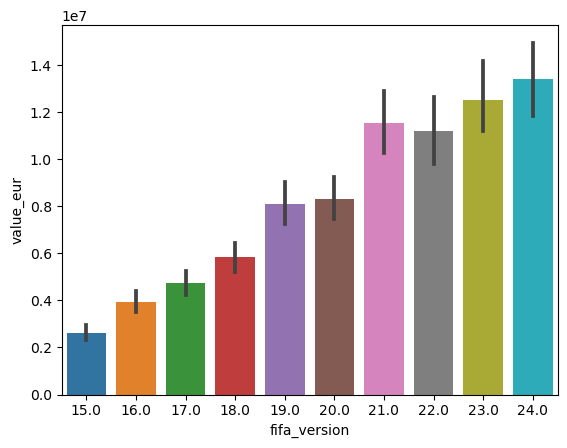

In [221]:
averages = {}

# loop through each fifa version
for version in df['fifa_version'].unique().tolist():
    # filter dataframe by version
    _df = df[df['fifa_version']==version]
    # extract average values using .mean() on column
    avg_value = round(_df['value_eur'].mean())
    avg_wage = round(_df['wage_eur'].mean())
    # create averages dictionary
    averages[version] = {}
    # save averages for version
    averages[version]['value_eur'] = avg_value
    averages[version]['wage_eur'] = avg_wage
    print(f'FIFA {version}')
    print('Avg value:', avg_value)
    print('Avg wage:', avg_wage, '\n')


adjusted_value_list = []
adjusted_wage_list = []
# loop through each row
for i, row in df.iterrows():
    # get version number
    _version = row['fifa_version']
    # adjust value & wage by calculated inflation ratios
    adjusted_value = row['value_eur'] * (averages[24]['value_eur'] / averages[_version]['value_eur'])
    adjusted_wage = row['wage_eur'] * (averages[24]['wage_eur'] / averages[_version]['wage_eur'])
    # append to list
    adjusted_value_list.append(adjusted_value)
    adjusted_wage_list.append(adjusted_wage)

# create new column from list of adjusted values
df['value_eur_adj'] = adjusted_value_list
df['wage_eur_adj'] = adjusted_wage_list

sns.barplot(df, x='fifa_version', y='value_eur')

In [219]:
#sns.barplot(df, x='fifa_version', y='value_eur_adj')

c:\Users\Ishina\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


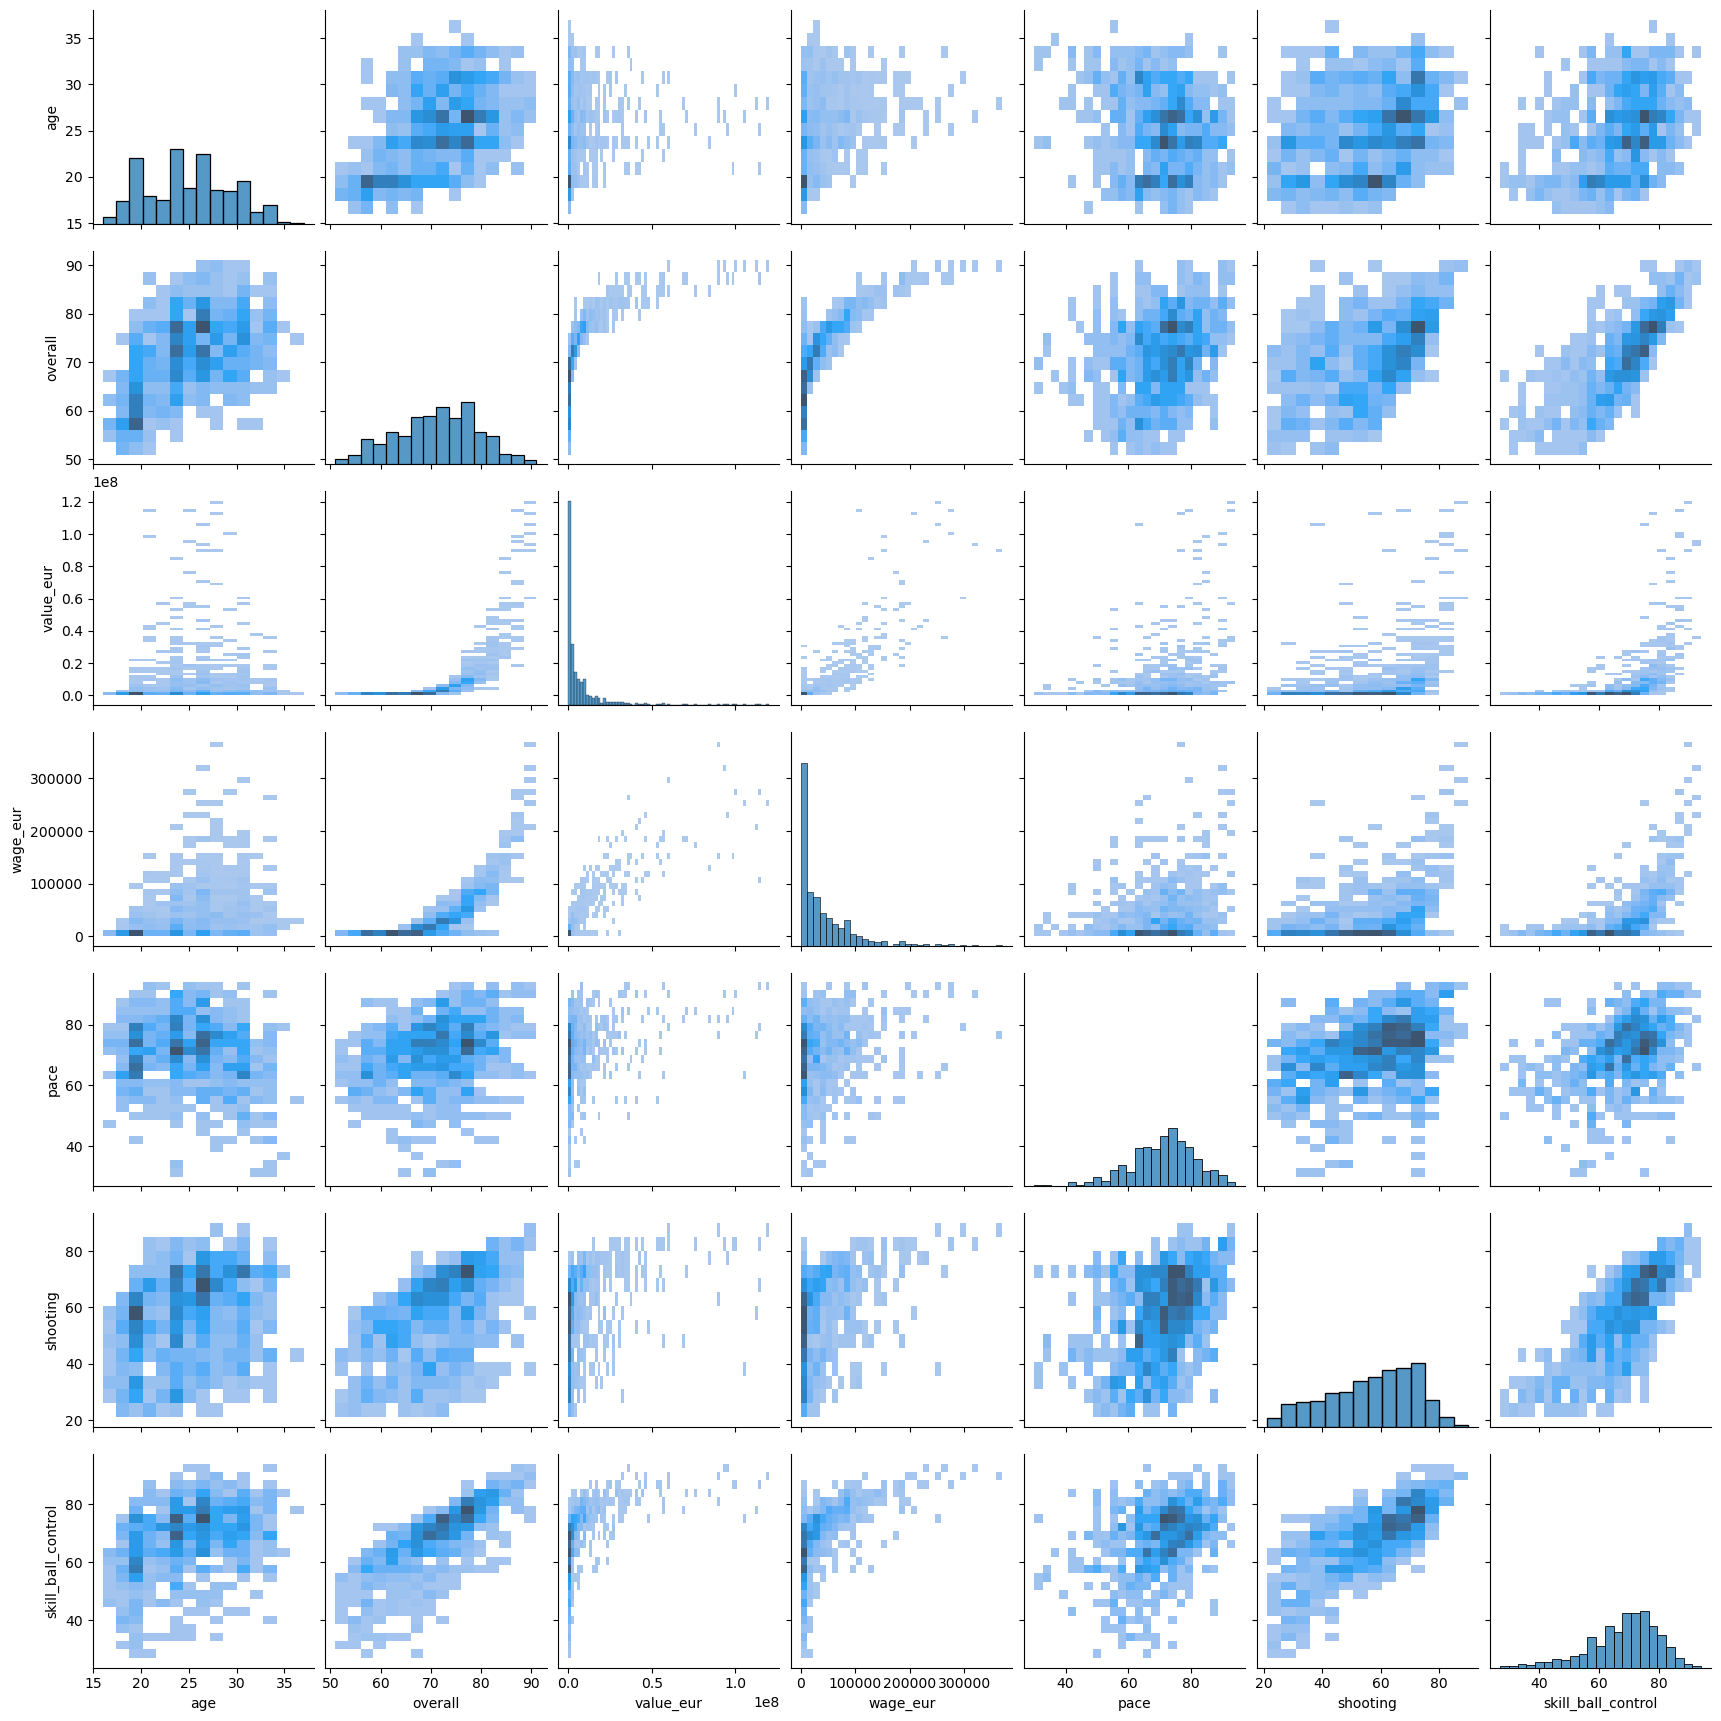

In [220]:
sns.pairplot(
    df.sample(frac=.1,),
    x_vars=['age','overall','value_eur','wage_eur','pace','shooting','skill_ball_control'],
    y_vars=['age','overall','value_eur','wage_eur','pace','shooting','skill_ball_control'],
    kind="hist"
)